### The code is specific to a given model and dataset; therefore, we need to manually adjust the model and datasets to complete the table in the main paper. Change the AREA_THRESHOLD = {'dc': 1000} from 1000 to 0 for OV-fidelity

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import Kitti
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import csv
import seaborn as sns
import os
import random
from PIL import Image, ImageEnhance
%matplotlib inline

In [2]:
seed_number = 4
torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [3]:
CONFIDENCE_THRESHOLD = 0.7 # 0.7 for both focs and fasterrcnn; and 0.3 for ssd300 (becasue predictions of ssd300 are with low confidence in general)
IOU_THRESHOLD = 0.5
AREA_THRESHOLD = {'dc': 1000} # set to 0 for OV-fidelity; object that is smaller than this is believed to be too far away, thus not safety-relevent
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:

# Load the pre-trained model (note that this is not really ideal, as the model has more classes based on COCO)
model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)  #fcos_resnet50_fpn; ssd300_vgg16; fasterrcnn_resnet50_fpn
model.to(device)
model.eval()


C:\Users\Zhao2_x\AppData\Local\anaconda3\envs\sa_fidelity\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Zhao2_x\AppData\Local\anaconda3\envs\sa_fidelity\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCOS_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FCOS_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCOS(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=1e

In [5]:
# Download and load the KITTI dataset
kitti_real_dataset = Kitti(root='data/data_real/',  transform=ToTensor(), download = False)
kitti_syn_dataset = Kitti(root='data/data_syn_Carla/',  transform=ToTensor(), download = False)
#KITTI_Syn_ControlNet_Canny; KITTI_Syn_ControlNet_Depth; KITTI_Syn_ControlNet_Canny; data_syn_Carla

# Get an image from the KITTI dataset
image_index=0

image_syn, _ = kitti_syn_dataset[image_index]
image_syn = image_syn.to(device)

In [6]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2, cat = "dc"):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.cat = cat

def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1.x1, box2.x1)
    y_top = max(box1.y1, box2.y1)
    x_right = min(box1.x2, box2.x2)
    y_bottom = min(box1.y2, box2.y2)

    # Calculate area of intersection
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate areas of the input boxes
    box1_area = (box1.x2 - box1.x1) * (box1.y2 - box1.y1)
    box2_area = (box2.x2 - box2.x1) * (box2.y2 - box2.y1)

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

def count_undetected_objects(ground_truths, predictions, iou_threshold, size_gt = 0):
    undetected_count = 0
    count_smaller = 0
    undetected_count_smaller = 0

    for gt_box in ground_truths:
        area = (gt_box.x2 - gt_box.x1) * (gt_box.y2 - gt_box.y1)        
        if area >= size_gt["dc"]:
            detected = False
            for pred_box in predictions:
                if calculate_iou(gt_box, pred_box) >= iou_threshold:
                    detected = True
                    break
            if not detected:
                undetected_count += 1
        else:
            count_smaller += 1
            detected = False
            for pred_box in predictions:
                if calculate_iou(gt_box, pred_box) >= iou_threshold:
                    detected = True
                    break
            if not detected:
                undetected_count_smaller += 1            


    return undetected_count, count_smaller, undetected_count_smaller

car
car
car
car


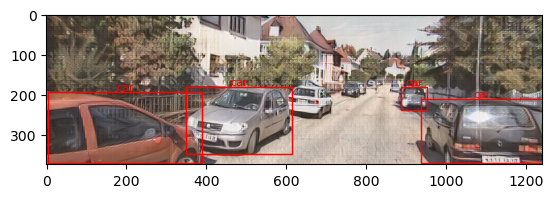

In [7]:


# Step 1: Convert PyTorch tensor to PIL Image
# Ensure tensor is in CPU and convert to PIL
img_pil = transforms.ToPILImage()(image_syn.cpu())

# Step 2: Enhance the image using Pillow
contrast_enhancer = ImageEnhance.Contrast(img_pil)
contrast_factor = 1
img_pil_enhanced = contrast_enhancer.enhance(contrast_factor)  # Example factor, adjust as needed

# Enhance the brightness
brightness_enhancer = ImageEnhance.Brightness(img_pil_enhanced)
brightness_factor = 1
img_pil_enhanced = brightness_enhancer.enhance(brightness_factor)  # Example factor, adjust as needed

# Enhance the saturation
saturation_enhancer = ImageEnhance.Color(img_pil_enhanced)
saturation_factor = 1
img_pil_enhanced = saturation_enhancer.enhance(saturation_factor)  # Example factor, adjust as needed

# Enhance the sharpness
sharpness_enhancer = ImageEnhance.Sharpness(img_pil_enhanced)
sharpness_factor = 1
img_pil_enhanced = sharpness_enhancer.enhance(sharpness_factor)  # Example factor, adjust as needed


# Step 3: Convert the enhanced PIL Image back to PyTorch tensor
transform = transforms.ToTensor()
image_syn_enhanced = transform(img_pil_enhanced)
image_syn_enhanced = image_syn_enhanced.to(device)

# Generate predictions for the image
with torch.no_grad():
    prediction = model([image_syn_enhanced])

# Display the image with the predicted bounding boxes
image_syn_enhanced = image_syn_enhanced.cpu()
prediction = prediction[0]
boxes = prediction['boxes'].cpu().numpy()
scores = prediction['scores'].cpu().numpy()
labels = prediction['labels'].cpu().numpy()
fig, ax = plt.subplots(1)
ax.imshow(image_syn_enhanced.permute(1, 2, 0))
for box, score, label in zip(boxes, scores, labels):
    if score > CONFIDENCE_THRESHOLD:

        x1, y1, x2, y2 = box
        ax.text((x1+x2)/2, y1, COCO_INSTANCE_CATEGORY_NAMES[label], ha='center', va='bottom', transform=ax.transData, fontsize=8, color='red')
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        print(COCO_INSTANCE_CATEGORY_NAMES[label])
plt.show()

In [8]:
# Creating a list from 0.5 to 1.5 with an increment of 0.1 using numpy's arange function

contrast_start = 0.8
contrast_end = 1.2

brightness_start = 0.8
brightness_end = 1.2

sharpness_start = 0.8
sharpness_end = 1.2

step = 0.1

contrast_elements_list = [round(i, 2) for i in np.arange(contrast_start, contrast_end + step, step)]
print(contrast_elements_list)

brightness_elements_list = [round(i, 2) for i in np.arange(brightness_start, brightness_end + step, step)]
print(brightness_elements_list)

sharpness_elements_list = [round(i, 2) for i in np.arange(sharpness_start, sharpness_end + step, step)]
print(sharpness_elements_list)

[0.8, 0.9, 1.0, 1.1, 1.2]
[0.8, 0.9, 1.0, 1.1, 1.2]
[0.8, 0.9, 1.0, 1.1, 1.2]


In [9]:
list_bounding_boxes_real = list()

for image_index in range(len(kitti_real_dataset)):


    bounding_boxes_real = list()

    # Get an image from the KITTI dataset
    image_real, _ = kitti_real_dataset[image_index]
    image_real = image_real.to(device)

    # Generate predictions for the image
    with torch.no_grad():
        prediction_real = model([image_real])

    # Display the image with the predicted bounding boxes
    image_real = image_real.cpu()
    prediction_real = prediction_real[0]
    boxes_real = prediction_real['boxes'].cpu().numpy()
    scores_real = prediction_real['scores'].cpu().numpy()

    for box_real, score_real in zip(boxes_real, scores_real):
        if score_real > CONFIDENCE_THRESHOLD:
            x1, y1, x2, y2 = box_real
            bounding_boxes_real.append(BoundingBox(x1, y1, x2, y2))

    list_bounding_boxes_real.append(bounding_boxes_real)

print(len(list_bounding_boxes_real))

90


In [10]:
min_inconsistency = 10000000
max_inconsistency = -10000000

contrast_best, brightness_best, sharpness_best = -1, -1, -1
contrast_worst, brightness_worst, sharpness_worst = -1, -1, -1


for contrast_factor in contrast_elements_list:
    for brightness_factor in brightness_elements_list:
        for sharpness_factor in sharpness_elements_list:
            
            inconsistency_count = 0
            
            for image_index in range(len(kitti_syn_dataset)):
                


                bounding_boxes_syn = list()

                # Get an image from the KITTI dataset
                image_syn, _ = kitti_syn_dataset[image_index]


                # Step 1: Convert PyTorch tensor to PIL Image
                # Ensure tensor is in CPU and convert to PIL
                img_pil = transforms.ToPILImage()(image_syn)

                # Step 2: Enhance the image using Pillow
                contrast_enhancer = ImageEnhance.Contrast(img_pil)
                img_pil_enhanced = contrast_enhancer.enhance(contrast_factor)  

                # Enhance the brightness
                brightness_enhancer = ImageEnhance.Brightness(img_pil_enhanced)
                img_pil_enhanced = brightness_enhancer.enhance(brightness_factor)  

                # Enhance the sharpness
                sharpness_enhancer = ImageEnhance.Sharpness(img_pil_enhanced)
                img_pil_enhanced = sharpness_enhancer.enhance(sharpness_factor) 


                # Step 3: Convert the enhanced PIL Image back to PyTorch tensor
                transform = transforms.ToTensor()
                image_syn_enhanced = transform(img_pil_enhanced)
                image_syn_enhanced = image_syn_enhanced.to(device)

                # Generate predictions for the image
                with torch.no_grad():
                    prediction = model([image_syn_enhanced])
                

                # Display the image with the predicted bounding boxes
                image_syn = image_syn.cpu()
                prediction_syn = prediction[0]
                boxes_syn = prediction_syn['boxes'].cpu().numpy()
                scores_syn = prediction_syn['scores'].cpu().numpy()

                for box_syn, score_syn in zip(boxes_syn, scores_syn):
                    if score_syn > CONFIDENCE_THRESHOLD:
                        x1, y1, x2, y2 = box_syn
                        bounding_boxes_syn.append(BoundingBox(x1, y1, x2, y2))

                undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(list_bounding_boxes_real[image_index], bounding_boxes_syn, IOU_THRESHOLD, AREA_THRESHOLD)
                inconsistency_count = inconsistency_count + undetected_count

                undetected_count, count_smaller, undetected_count_smaller = count_undetected_objects(bounding_boxes_syn, list_bounding_boxes_real[image_index], IOU_THRESHOLD, AREA_THRESHOLD)
                inconsistency_count = inconsistency_count + undetected_count
            
            print(contrast_factor, brightness_factor, sharpness_factor, inconsistency_count, sep=', ')
            
            if (inconsistency_count < min_inconsistency):
                min_inconsistency = inconsistency_count
                contrast_best, brightness_best, sharpness_best = contrast_factor, brightness_factor, sharpness_factor
            if (inconsistency_count > max_inconsistency):
                max_inconsistency = inconsistency_count
                contrast_worst, brightness_worst, sharpness_worst = contrast_factor, brightness_factor, sharpness_factor        

0.8, 0.8, 0.8, 121
0.8, 0.8, 0.9, 119
0.8, 0.8, 1.0, 119
0.8, 0.8, 1.1, 122
0.8, 0.8, 1.2, 122
0.8, 0.9, 0.8, 119
0.8, 0.9, 0.9, 119
0.8, 0.9, 1.0, 122
0.8, 0.9, 1.1, 123
0.8, 0.9, 1.2, 123
0.8, 1.0, 0.8, 116
0.8, 1.0, 0.9, 118
0.8, 1.0, 1.0, 118
0.8, 1.0, 1.1, 118
0.8, 1.0, 1.2, 118
0.8, 1.1, 0.8, 115
0.8, 1.1, 0.9, 112
0.8, 1.1, 1.0, 113
0.8, 1.1, 1.1, 116
0.8, 1.1, 1.2, 112
0.8, 1.2, 0.8, 111
0.8, 1.2, 0.9, 110
0.8, 1.2, 1.0, 111
0.8, 1.2, 1.1, 112
0.8, 1.2, 1.2, 113
0.9, 0.8, 0.8, 120
0.9, 0.8, 0.9, 120
0.9, 0.8, 1.0, 120
0.9, 0.8, 1.1, 123
0.9, 0.8, 1.2, 122
0.9, 0.9, 0.8, 118
0.9, 0.9, 0.9, 119
0.9, 0.9, 1.0, 122
0.9, 0.9, 1.1, 123
0.9, 0.9, 1.2, 121
0.9, 1.0, 0.8, 112
0.9, 1.0, 0.9, 111
0.9, 1.0, 1.0, 112
0.9, 1.0, 1.1, 115
0.9, 1.0, 1.2, 116
0.9, 1.1, 0.8, 111
0.9, 1.1, 0.9, 109
0.9, 1.1, 1.0, 110
0.9, 1.1, 1.1, 111
0.9, 1.1, 1.2, 111
0.9, 1.2, 0.8, 114
0.9, 1.2, 0.9, 111
0.9, 1.2, 1.0, 112
0.9, 1.2, 1.1, 114
0.9, 1.2, 1.2, 113
1.0, 0.8, 0.8, 117
1.0, 0.8, 0.9, 120
1.0, 0.8, 1.

In [11]:
print("the best configuration and its inconsistent prediction number:", contrast_best, brightness_best, sharpness_best,min_inconsistency)
print("the worst configuration and its inconsistent prediction number:",contrast_worst, brightness_worst, sharpness_worst,max_inconsistency)

the best configuration and its inconsistent prediction number: 1.2 1.2 0.8 105
the worst configuration and its inconsistent prediction number: 0.8 0.9 1.1 123
